In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(asctime)s - %(message)s')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import whisper

import tiktoken
whisper_tokenizer = whisper.tokenizer.get_tokenizer(tiktoken.get_encoding(tiktoken.list_encoding_names()[-1]), num_languages=1)

from pydub import AudioSegment
from pyannote.audio import Pipeline
import json

with open('config.json') as fileobj:
    hf_token = json.load(fileobj)['hugging_face_token']

pyannote_pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization-3.1', use_auth_token=hf_token)

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pyannote_pipeline.to(device)

# TODO: silence ReproducibilityWarning
# TODO: silence UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio

import os
import pickle
import difflib
from itertools import chain

from IPython.display import clear_output
clear_output()

import utils
import data_extraction as da

whisper_model = 'turbo'

audio_dir = os.path.join('data', 'audio-vault')
transcription_dir = os.path.join(audio_dir, 'transcriptions')
diarization_dir = os.path.join(audio_dir, 'diarization_segments')

vsd_dir = os.path.join('data', 'VSD', 'VSD2014_officialrelease', 'VSD_2014_December_official_release', 'Hollywood-dev')
vsd_features_dir = os.path.join(vsd_dir, 'features')
vsd_annotations_dir = os.path.join(vsd_dir, 'annotations')

utils.ensure_dir_exists(transcription_dir)

transcript_df_fp = '{movie_name}-transcript.parquet'
annot_cats = ['blood', 'carchase', 'coldarms', 'explosions', 'fights', 'fire', 'firearms', 'gore', 'gunshots', 'screams']

# TODO:
Goal is to identify parts of audio transcript that align with violent scenes

1) Find dialogue either side of timestamped violence in subtitles
2) Get dialogue from narration
3) Match bookends with narration, assess length of newly created scene (words/timestamps)



To assess if no further progress is made with matching:
    temperature, avg_logprob, compression_ratio, no_speech_prob

In [3]:
subs_dict = da.extract_subs()

for movie, subs_df in subs_dict.items():
    subs_df['tokens'] = subs_df['raw_dialogue'].apply(lambda x: whisper_tokenizer.encode(x))

Utilised following repo for diarization https://github.com/Majdoddin/nlp/blob/main/Pyannote_plays_and_Whisper_rhymes_v_2_0.ipynb

In [4]:
# Torch (pyannote) isn't familiar with MP3 files, so convert to wav for effective performance

mp3_files = [x for x in os.listdir(audio_dir) if os.path.splitext(x)[-1] == '.mp3']

for mp3_filename in mp3_files:
    movie_name = utils.remove_ext(mp3_filename)
    
    if not os.path.exists(os.path.join(audio_dir, movie_name + '.wav')):
        logging.info(f'.wav file missing for {movie_name}, converting ...')
        audio = AudioSegment.from_mp3(os.path.join(audio_dir, mp3_filename))
        audio.export(os.path.join(audio_dir, movie_name + '.wav'), format="wav")

In [5]:
seg_df_list = []
wav_files = [x for x in os.listdir(audio_dir) if os.path.splitext(x)[-1] == '.wav']

for wav_filename in wav_files:
    movie_name = utils.remove_ext(wav_filename)
    seg_df_path = os.path.join(diarization_dir, f'{movie_name}-diarization.parquet')
    
    if not os.path.exists(seg_df_path):
        logging.info(f'Started pyannote pipeline for {movie_name}')
        dz = pyannote_pipeline({'audio': os.path.join(audio_dir, wav_filename)})
        
        # Extract start and end times from segments object and split integer out from 'SPEAKER_x' labels
        records = [(x[0].start, x[0].end, int(x[2].split('_')[-1])) for x in dz.itertracks(yield_label = True)]
        segments_df = pd.DataFrame(records, columns=['start', 'end', 'speaker'])
        
        # Assume narrator speaks first (describing opening logos etc)
        narrator_id = segments_df['speaker'].iloc[0]
        segments_df['is_dialogue'] = segments_df['speaker'].ne(narrator_id)
        segments_df['movie_name'] = movie_name
        
        segments_df.to_parquet(seg_df_path)
        
    seg_df_list.append(pd.read_parquet(seg_df_path))
    
full_seg_df = pd.concat(seg_df_list)

whisper_sr = 16000
full_seg_df['start_frame'] = (whisper_sr * full_seg_df['start']).astype(int)
full_seg_df['end_frame'] = (whisper_sr * full_seg_df['end']).astype(int)

In [8]:
model = whisper.load_model(whisper_model, device=device)

# Quote from repo: "pyannote.audio seems to miss the first 0.5 seconds of the audio, and, therefore, we prepend a spcacer"
# spacer = AudioSegment.silent(duration=2000)

full_seg_df_list = []

for wav_filename in wav_files:
    movie_name = utils.remove_ext(wav_filename)
    
    curr_transcript_fp = os.path.join(transcription_dir, transcript_df_fp.format(movie_name=movie_name))
    
    if not os.path.exists(curr_transcript_fp):
        audio = whisper.load_audio(os.path.join(audio_dir, wav_filename))
        segments_df = full_seg_df[full_seg_df.movie_name.eq(movie_name)]
        seg_start_arr, seg_end_arr = segments_df['start_frame'].values, segments_df['end_frame'].values
        
        segment_list = []

        for ii in range(len(seg_start_arr)):
            if ii % 50 == 0:
                logging.info(f'{movie_name} Segment: {ii + 1} / {len(seg_start_arr)}')
            segment = audio[seg_start_arr[ii]: seg_end_arr[ii]]
            
            # TODO:Add word_timestamps=True, to get greater precision once pipeline works
            segment_list.append(model.transcribe(segment)) 
        
        segments_df['text'] = [x['text'] for x in segment_list]
        segments_df['tokens'] = [list(chain.from_iterable([y['tokens'] for y in x['segments']])) for x in segment_list]
        
        segments_df.to_parquet(curr_transcript_fp)
        
    full_seg_df_list.append(pd.read_parquet(curr_transcript_fp))
    
full_seg_df = pd.concat(full_seg_df_list)

/home/eye4got/projects/honours-thesis/.venv/lib/python3.11/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, m

In [4]:
# https://github.com/linto-ai/whisper-timestamped

In [10]:
# transcript_df['start_time'] = pd.to_timedelta(transcript_df['start'], unit='s')
# transcript_df['end_time'] = pd.to_timedelta(transcript_df['end'], unit='s')

# Whisper adds whitespace which affects tokens
full_seg_df['text'] = full_seg_df['text'].str.strip()
full_seg_df['tokens'] = full_seg_df['text'].apply(lambda x: whisper_tokenizer.encode(x))

In [12]:
curr_movie = 'SavingPrivateRyan'
curr_sub_df = subs_dict[curr_movie].copy()
curr_transcript_df = full_seg_df[full_seg_df['movie_name'].eq(curr_movie)]

curr_sub_df = curr_sub_df.drop(columns=['raw_time_str', 'raw_start_time', 'raw_end_time'])

In [14]:
transcript_arr = curr_transcript_df['tokens'].values
sub_arr = curr_sub_df['tokens'].values
sub_trans_idx = np.zeros(len(sub_arr), dtype=np.int32)
idx_updates = np.zeros(len(sub_arr), dtype=np.int32)

### First pass, find maximum match
for ii in range(len(sub_arr)):
    max_ratio = 0
    last_found = 0
    
    for jj in range(len(sub_trans_idx)):
        seq_match = difflib.SequenceMatcher(None, sub_arr[ii], transcript_arr[jj])
        if seq_match.ratio() > max_ratio:
            max_ratio = seq_match.ratio()
            last_found = jj
            
    sub_trans_idx[ii] = last_found
    
curr_sub_df['max_ratio_idx'] = sub_trans_idx
    
### Second pass, interpolate where single value is obviously wrong
curr_sub_df['diff'] = curr_sub_df['max_ratio_idx'].diff()
# Find when segments "go backwards", adding a false at the beginning as comparisons result in array one shorter than length
# curr_sub_df['not_incr'] = np.concatenate([[False], sub_trans_idx[:len(sub_trans_idx) - 1] > sub_trans_idx[1:]])

for ii in curr_sub_df.index[curr_sub_df['diff'].lt(-5)].drop(curr_sub_df.shape[0]-1, errors='ignore'):
    
    prev_diff, curr_diff, next_diff = curr_sub_df['diff'].iloc[ii-1:ii+2]
    fix_prev = False
    fix_curr = False
    
    if (0 < prev_diff + curr_diff < 10) and (curr_diff + next_diff < -5):
        search_start = curr_sub_df['max_ratio_idx'].iloc[ii-2]
        search_end = curr_sub_df['max_ratio_idx'].iloc[ii]
        fix_prev = True
    elif (0 < curr_diff + next_diff < 10) and (curr_diff + prev_diff < -5):
        search_start = curr_sub_df['max_ratio_idx'].iloc[ii-1]
        search_end = curr_sub_df['max_ratio_idx'].iloc[ii+1]
        fix_curr = True
        
    if fix_prev or fix_curr:
        max_ratio = 0
        last_found = 0
        
        for jj in range(search_start + 1, search_end):
            seq_match = difflib.SequenceMatcher(None, sub_arr[ii], transcript_arr[jj])
            if seq_match.ratio() > max_ratio:
                max_ratio = seq_match.ratio()
                last_found = jj
                
        update_idx = ii if fix_curr else ii - 1
        idx_updates[update_idx] = last_found
        

<Axes: >

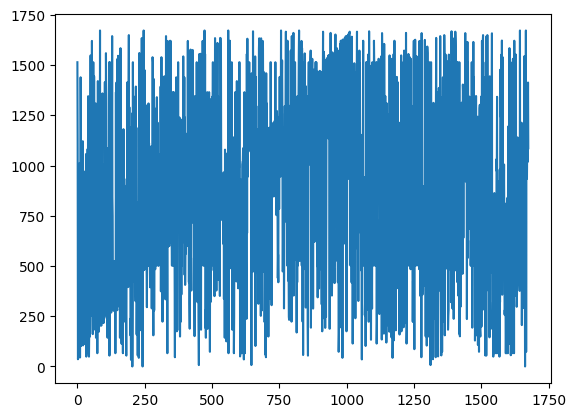

In [16]:
curr_sub_df['max_ratio_idx'].plot()

In [12]:
curr_sub_df.drop(columns=['start_time', 'end_time', 'tokens'])

,raw_dialogue,max_ratio_idx,diff
0,Father.,334,NaN
1,6 Jun 1944.,43,-291.0
2,Sektor Dog Green Pantai Omaha.,44,1.0
3,Clear the ramp! 30 seconds! May God bless you ...,54,10.0
4,"Troops left and right the ship, clear climb ou...",92,38.0
...,...,...,...
1670,James.,1130,-515.0
1671,"""Kapten John H Miller.""",1643,513.0
1672,- Say that my life is good. - What?,838,-805.0
1673,Say that I am a good person.,1047,209.0


In [24]:
ii = 2
curr_transcript_df[['id', 'text']].iloc[20*ii:20*(ii+1)].values

array([[40, 'We draw closer until his frosty blue eyes fill our view.'],
       [41,
        'Now, on a beachhead, X-shaped obstacles jut out of the water.'],
       [42, 'Words appear.'],
       [43, 'June 6, 1944.'],
       [44, 'Dog Green Sector, Omaha Beach.'],
       [45,
        'Out at sea, landing crafts loaded with GIs bounce through heavy surf.'],
       [46, 'One man vomits over the side.'],
       [47,
        "Another soldier's hand trembles as he unscrews his canteen."],
       [48,
        "He takes a drink, and we glimpse Captain's bars painted on his steel pot helmet."],
       [49, 'The Captain has tight, thin lips.'],
       [50, 'A greenish cast colors his tense face.'],
       [51,
        'He looks around uneasily at the two rows of men crammed into the small craft.'],
       [52,
        'A round-faced sergeant stuffs a wad of chewing tobacco in his mouth.'],
       [53, 'A GI pukes, then another.'],
       [54, 'Clear the room!'],
       [55, '30 seconds!'],
   

In [34]:
curr_sub_df['updates'] = idx_updates
curr_sub_df[['max_ratio_idx', 'diff', 'updates']].iloc[500:600]

,max_ratio_idx,diff,updates
500,302,-569.0,0
501,999,697.0,0
502,876,-123.0,0
503,301,-575.0,878
504,879,578.0,0
...,...,...,...
595,1015,1.0,0
596,1017,2.0,0
597,1123,106.0,1020
598,1021,-102.0,0


In [ ]:
curr_sub_df['smoothed_ratio_idx'] = curr_sub_df['max_ratio_idx'].rolling(11, center=True, min_periods=1).mean()
curr_sub_df['diff_ratio'] = np.abs((curr_sub_df['max_ratio_idx'] / curr_sub_df['smoothed_ratio_idx']) - 1)
curr_sub_df['high_diff'] = curr_sub_df['diff_ratio'].gt(0.2)

# curr_sub_df = curr_sub_df.drop(columns=['raw_start_time', 'raw_end_time', 'raw_time_str', 'tokens'])

In [ ]:
outliers = [39, 102, 153, 182, 187, 189, 199, 203, 206, 207, 209, 219]

In [66]:
ii = 7
curr_sub_df[['max_ratio_idx']].iloc[30*ii:30*(ii+1)]

,max_ratio_idx
210,363
211,364
212,365
213,367
214,369
215,370
216,372
217,373
218,376
219,107


In [191]:
incr_arr = sub_trans_idx[:len(sub_trans_idx) - 1] > sub_trans_idx[1:]
doubles_arr = incr_arr[1:] & incr_arr[:len(incr_arr) - 1]
triples_arr = doubles_arr[1:] & doubles_arr[:len(doubles_arr) - 1]
quad_arr = triples_arr[1:] & triples_arr[:len(triples_arr) - 1]

In [179]:
sub_trans_idx[362:374]

array([ 626,  628,  629,  566, 3340,  675,  633,  634,  636,  637,  640,
        641], dtype=int32)

In [193]:
np.arange(len(quad_arr))[quad_arr]

array([1076])

In [153]:
curr_sub_df = curr_sub_df.set_index(sub_trans_idx)

combined_df = curr_transcript_df.join(curr_sub_df.add_prefix('sub_'))

In [ ]:
raw_dev_movies = [x.split('_')[0] for x in os.listdir(vsd_annotations_dir)]
cat_breakdown = {movie: raw_dev_movies.count(movie) > 1 for movie in set(raw_dev_movies)}

NameError: name 'raw_dev_movies' is not defined

In [ ]:
df_list = []
annotation_fps = os.listdir(vsd_annotations_dir)

for movie in transcriptions.keys():
    for annot_filepath in [x for x in annotation_fps if movie in x]:
        cat = utils.remove_ext(annot_filepath.split('_')[1])
        raw_annot_df = da.extract_vsd_annotations(os.path.join(vsd_annotations_dir, annot_filepath))
        raw_annot_df['movie'] = movie
        raw_annot_df['annotation_cat'] = cat
        df_list.append(raw_annot_df)
        
annotations_df = pd.concat(df_list)

In [37]:
import h5py
f = h5py.File(os.path.join(vsd_features_dir, 'IAmLegend_auditory.mat'))
print(list(f.keys()))

# Amplitude-Envelope
# Band Energy Ratio
# Bandwidth
# Mel-Frequency Cepstral Coefficient
# Root Mean Square Energy
# Spectral Centroid
# Spectral Flux
# Zero-Crossing Rate

import numpy as np
raw_data = f.get('BW')
data = np.array(raw_data)

['AE', 'BER', 'BW', 'MFCC', 'RMS', 'SC', 'SF', 'ZCR']
